
## Loading and Preprocessing the Dataset

**Dataset:Twitter US Airline Sentiment ->Tweets.csv**<br>
**Database :database.sqlite**

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# nltk
import nltk
nltk.download('stopwords')

## Preprocessing libraries
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# For Model training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC              # a variant of SVC optimized for large datasets

# Metrics for accuracy
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dharshan.S\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Reading our dataset

In [3]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### EDA

In [4]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

### Checking the distribution of airlines

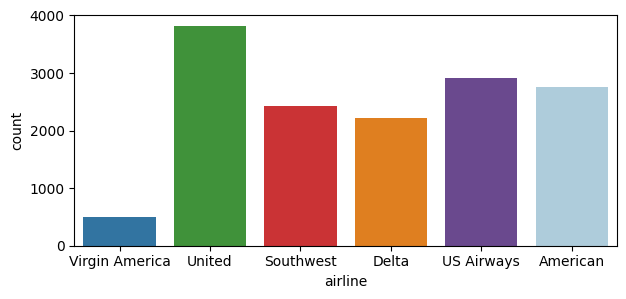

In [5]:

plt.figure(figsize=(7, 3))
sns.countplot(data=df, x='airline', hue='airline', palette=['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#a6cee3'], legend=False)
plt.show()


### Seeing the distribution of positive and negative tweet reviews in target column

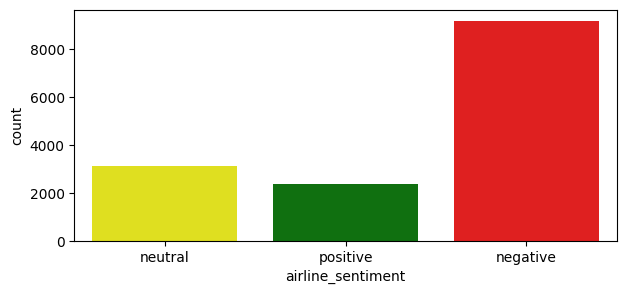

In [6]:
plt.figure(figsize=(7, 3))
sns.countplot(data=df, x='airline_sentiment', hue='airline_sentiment', palette=['yellow', 'green', 'red'], legend=False)
plt.show()


### CALCULATION 

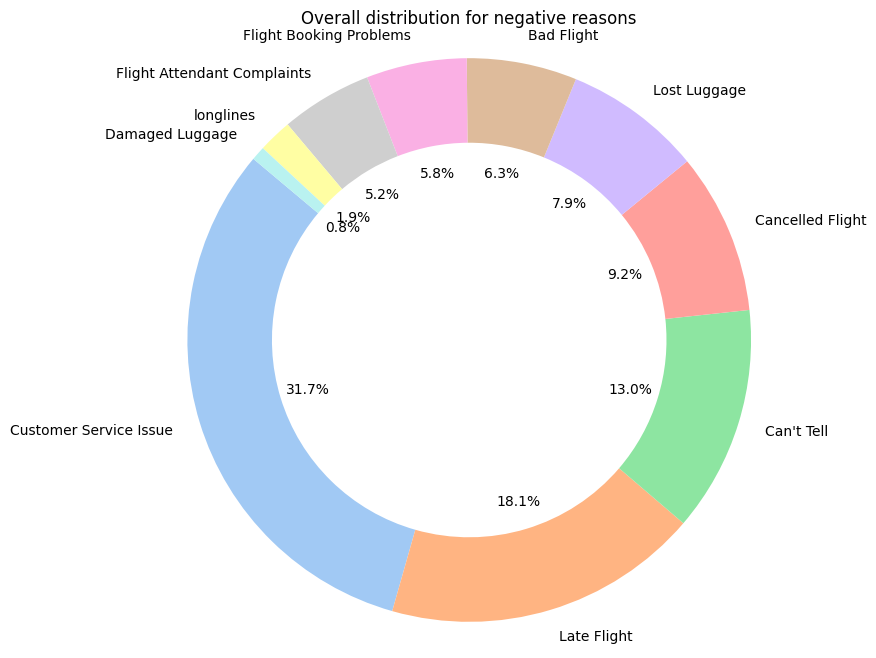

In [7]:
# Calculate the value counts for each negative reason
value_counts = df['negativereason'].value_counts()

# Create a donut-like pie chart using matplotlib and seaborn
plt.figure(figsize=(8, 8))
labels = value_counts.index
values = value_counts.values
colors = sns.color_palette('pastel')[0:len(labels)]  # Use pastel colors for the chart
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Overall distribution for negative reasons')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is drawn as a circle.
plt.show()

### Data clearing and preprocessing of Text

In [8]:
corpus = []
ps = PorterStemmer()
for i in range(len(df)):
    # Removing special characters from text (message)
    review = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    
    # Converting entire text into lowercase
    review = review.lower()
    
    # Splitting our text into words
    review = review.split()
    
    # Stemming and removing stopwords
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    
    # Joining all the words into a complete text
    review = ' '.join(review)
    
    # Appending each text into the list corpus
    corpus.append(review)


In [9]:


cv = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)


In [10]:
# We will use X as independent feature section
X = cv.fit_transform(corpus)
# We will use y as dependent feature section
y=df['airline_sentiment']

In [11]:
print('No. of feature_words: ', len(cv.get_feature_names_out()))

No. of feature_words:  91436


In [12]:
import pickle

# Creating a pickle file for the TfidfVectorizer
with open('cv-transform.pkl', 'wb') as f:
    pickle.dump(cv, f)


In [13]:
import pickle

# Load the contents of the pickle file
with open('cv-transform.pkl', 'rb') as f:
    loaded_cv = pickle.load(f)

# Now you can inspect the loaded object
print(loaded_cv)

# You can also access the attributes and methods of the loaded object, depending on what it is
print(loaded_cv.get_feature_names_out())


TfidfVectorizer(max_features=500000, ngram_range=(1, 2))
['aa' 'aa abi' 'aa abl' ... 'zzkqwwbjz' 'zzp' 'zzp ywve']


## Model Training using NLP Techniques

### Model training

In [20]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)
# Training using three algorithms, let's see which will give us better result
model1=LogisticRegression()
model2=BernoulliNB()
model3=LinearSVC()
model=[model1, model2, model3]
i = 0
for algo in model:
  i += 1
  print("M-O-D-E-L :",i)
  algo.fit(X_train, y_train)
  y_pred=algo.predict(X_test)
  # Checking the accuracy
  print("Confusion matrix : \n",confusion_matrix(y_pred,y_test))
  print("Accuracy score : ",accuracy_score(y_pred,y_test))
  print("Classification Report : \n",classification_report(y_pred,y_test))
  print("-----------------------------------------------------------\n")

from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building a sentiment classification model (Random Forest Classifier in this example)
model4 = RandomForestClassifier(n_estimators=100, random_state=0)  # Define Model 4 as Random Forest
model4.fit(X_train, y_train)

# Making predictions
y_pred = model4.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Model 4 (Random Forest) - Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')


M-O-D-E-L : 1
Confusion matrix : 
 [[2694  532  285]
 [  77  351   81]
 [  17   36  319]]
Accuracy score :  0.7659380692167578
Classification Report : 
               precision    recall  f1-score   support

    negative       0.97      0.77      0.86      3511
     neutral       0.38      0.69      0.49       509
    positive       0.47      0.86      0.60       372

    accuracy                           0.77      4392
   macro avg       0.60      0.77      0.65      4392
weighted avg       0.86      0.77      0.79      4392

-----------------------------------------------------------

M-O-D-E-L : 2
Confusion matrix : 
 [[2780  850  670]
 [   8   69   13]
 [   0    0    2]]
Accuracy score :  0.6491347905282332
Classification Report : 
               precision    recall  f1-score   support

    negative       1.00      0.65      0.78      4300
     neutral       0.08      0.77      0.14        90
    positive       0.00      1.00      0.01         2

    accuracy                      

## Insights Generation

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


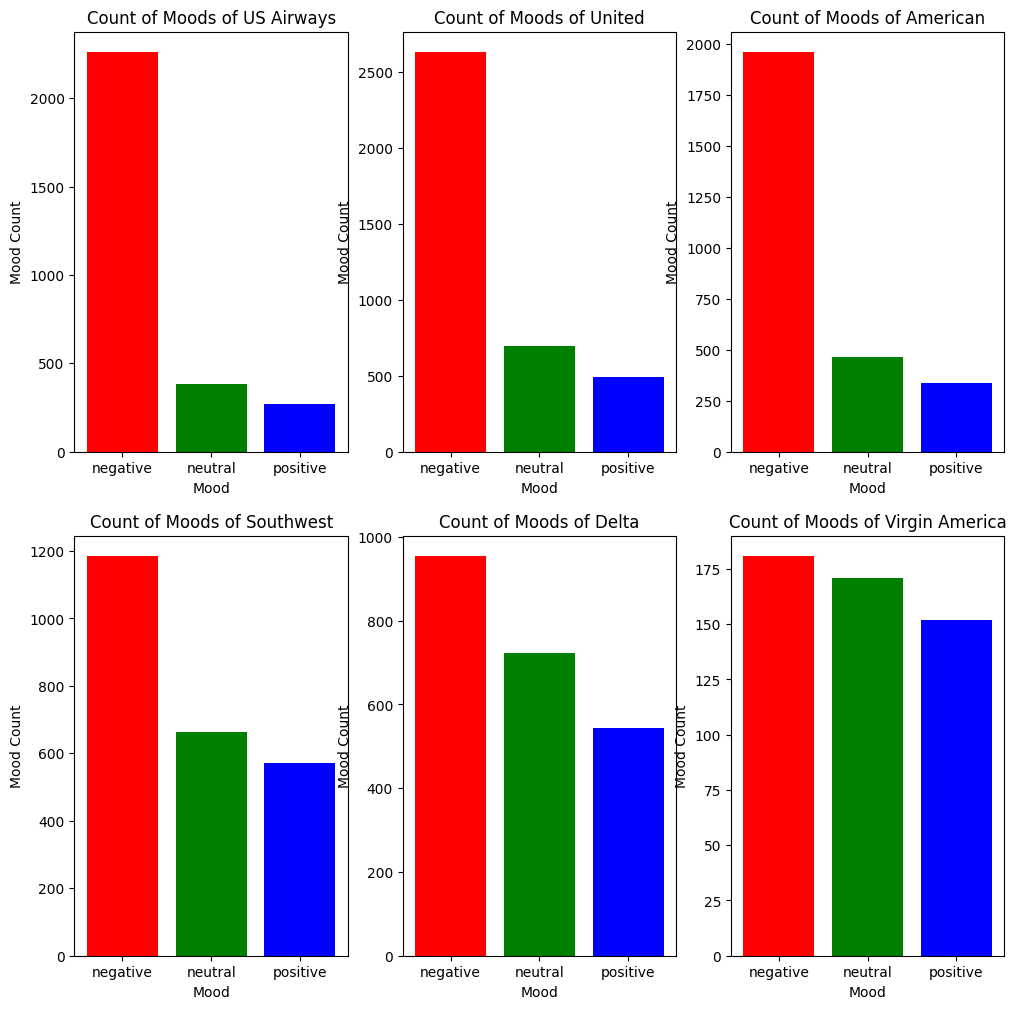

In [15]:

print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

            Percent Positive
American            0.121783
Delta               0.244824
Southwest           0.235537
US Airways          0.092345
United              0.128728
Virgin              0.301587


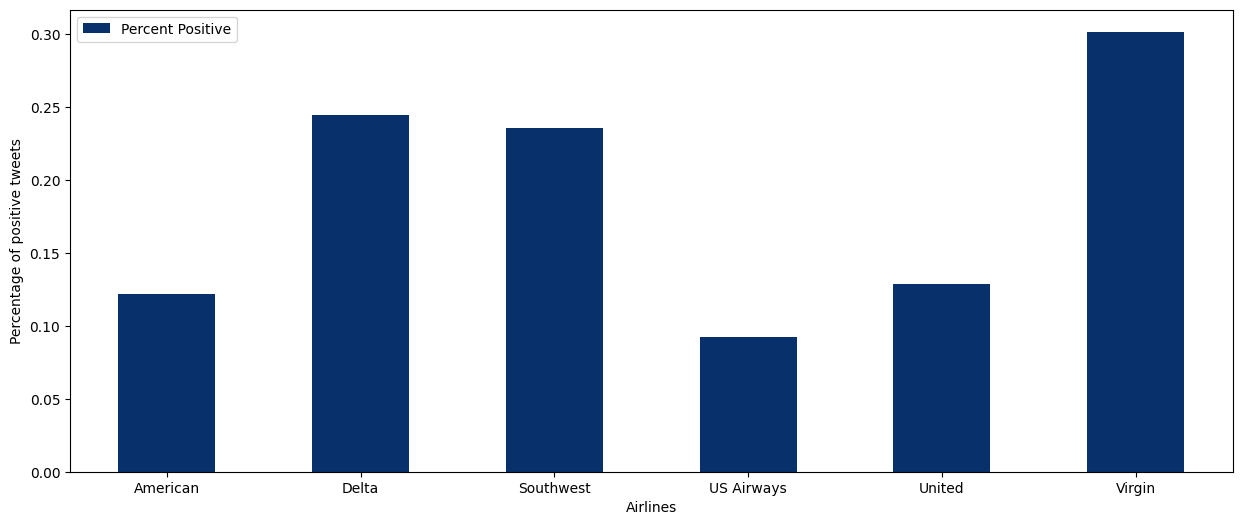

In [21]:
# Percentage of Positive Tweets in Each Airlines
pos_tweets = df.groupby(['airline', 'airline_sentiment']).count().iloc[:, 0]
total_tweets = df.groupby(['airline'])['airline_sentiment'].count()

my_dict = {'American': pos_tweets[2] / total_tweets[0], 'Delta': pos_tweets[5] / total_tweets[1], 'Southwest': pos_tweets[8] / total_tweets[2],
           'US Airways': pos_tweets[11] / total_tweets[3], 'United': pos_tweets[14] / total_tweets[4], 'Virgin': pos_tweets[17] / total_tweets[5]}
perc = pd.DataFrame.from_dict(my_dict, orient='index')
perc.columns = ['Percent Positive']
print(perc)
ax = perc.plot(kind='bar', rot=0, colormap='Blues_r', figsize=(15, 6))
ax.set_xlabel('Airlines')
ax.set_ylabel('Percentage of positive tweets')
plt.show()


            Percent Negative
American            0.710402
Delta               0.429793
Southwest           0.490083
US Airways          0.776862
United              0.688906
Virgin              0.359127


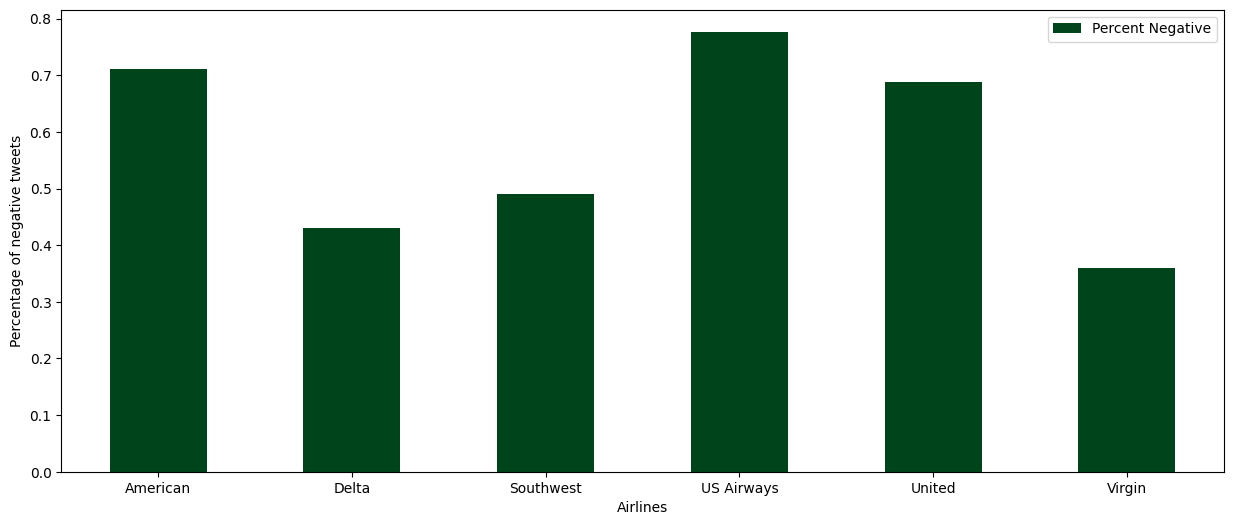

In [22]:
#Percentage of Negative Tweets in Each Airlines
neg_tweets = df.groupby(['airline','airline_sentiment']).count().iloc[:,0]
total_tweets = df.groupby(['airline'])['airline_sentiment'].count()

my_dict = {'American':neg_tweets[0] / total_tweets[0],'Delta':neg_tweets[3] / total_tweets[1],'Southwest': neg_tweets[6] / total_tweets[2],
'US Airways': neg_tweets[9] / total_tweets[3],'United': neg_tweets[12] / total_tweets[4],'Virgin': neg_tweets[15] / total_tweets[5]}
perc = pd.DataFrame.from_dict(my_dict, orient = 'index')
perc.columns = ['Percent Negative']
print(perc)
ax = perc.plot(kind = 'bar', rot=0, colormap = 'Greens_r', figsize = (15,6))
ax.set_xlabel('Airlines')
ax.set_ylabel('Percentage of negative tweets')
plt.show()

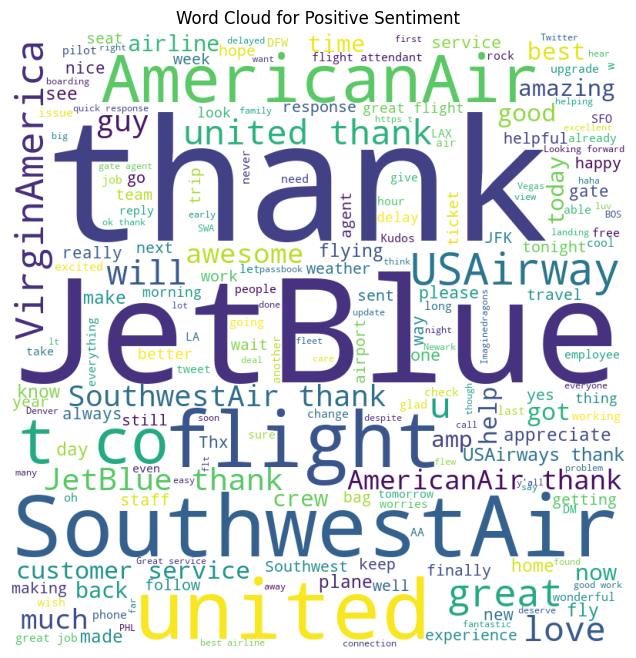

In [27]:
from wordcloud import WordCloud

positive_reviews = ' '.join(df[df['airline_sentiment'] == 'positive']['text'])
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(positive_reviews)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud for Positive Sentiment")
plt.show()



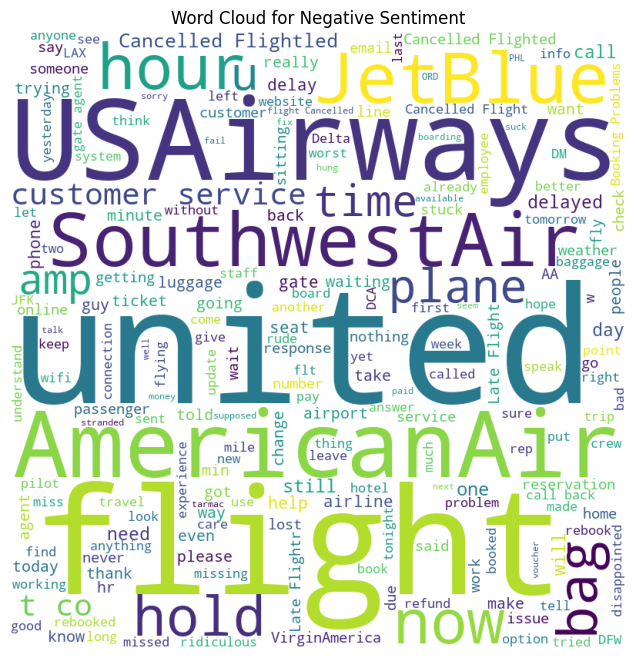

In [29]:
# Word cloud for negative sentiment
negative_reviews = ' '.join(df[df['airline_sentiment'] == 'negative']['text'])
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(negative_reviews)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud for Negative Sentiment")
plt.show()


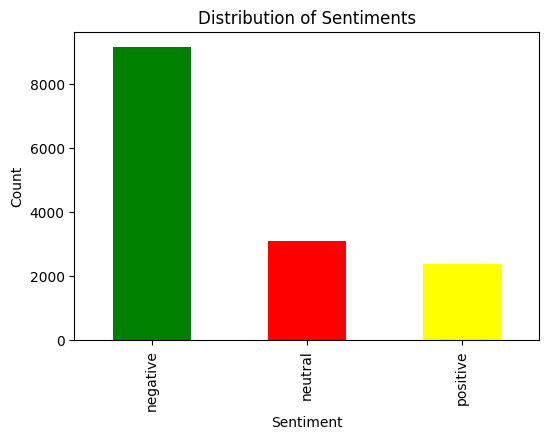

In [30]:
# Example of a bar chart to show the distribution of sentiments
sentiment_counts = df['airline_sentiment'].value_counts()
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'yellow'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

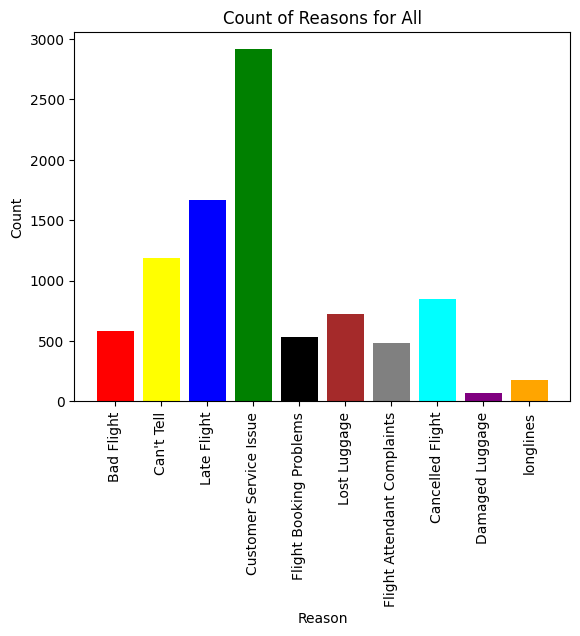

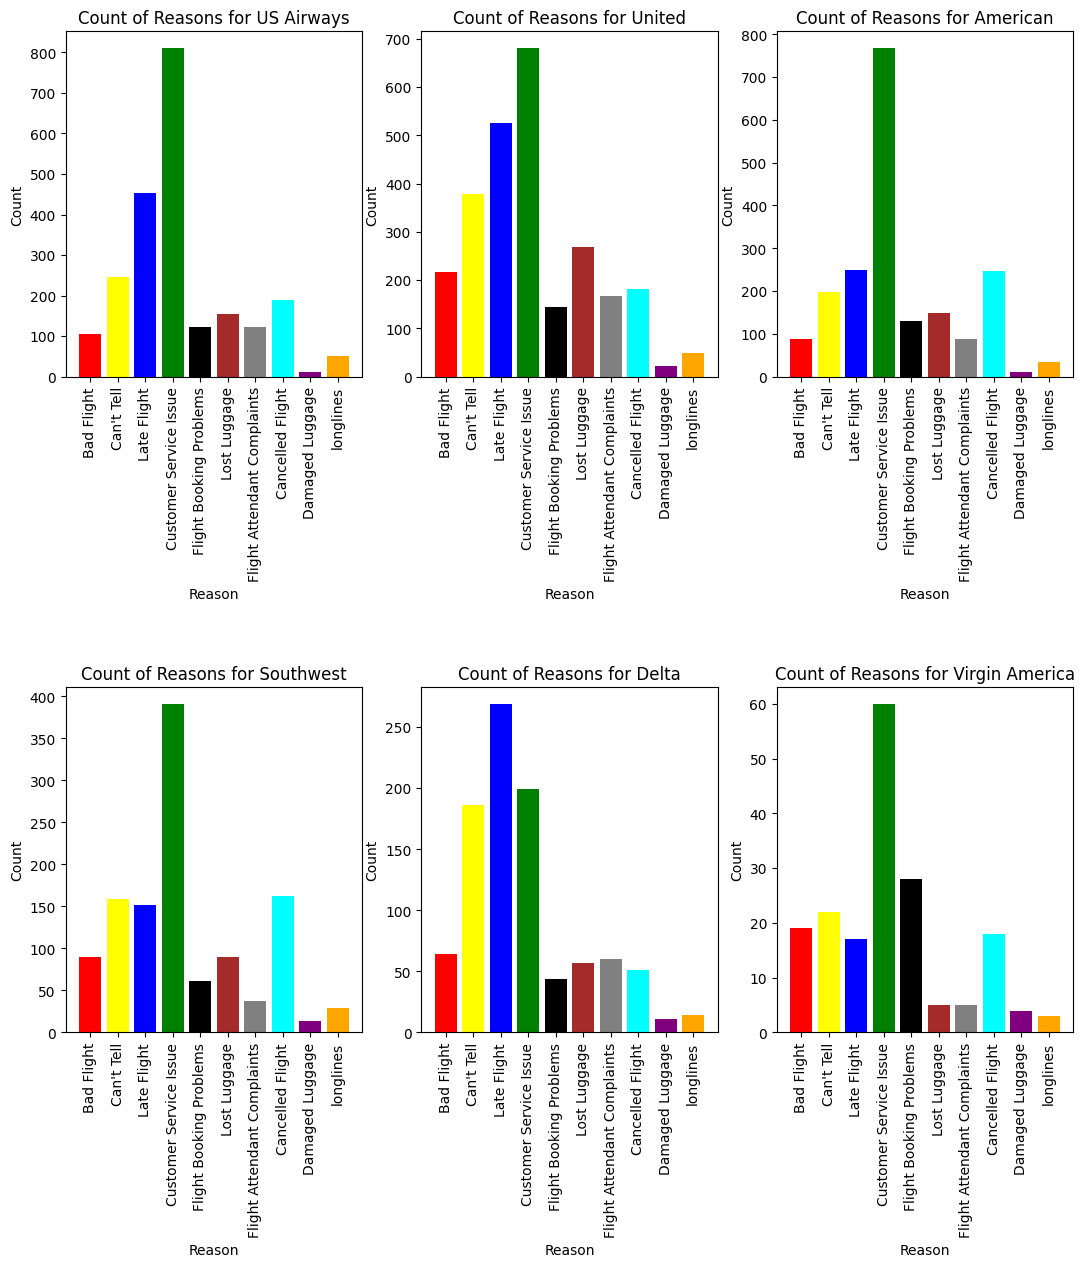

In [31]:
#Count of Negative Reasons for all Airlines
df['negativereason'].nunique()

NR_Count=dict(df['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=df
    else:
        a=df[df['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
    
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

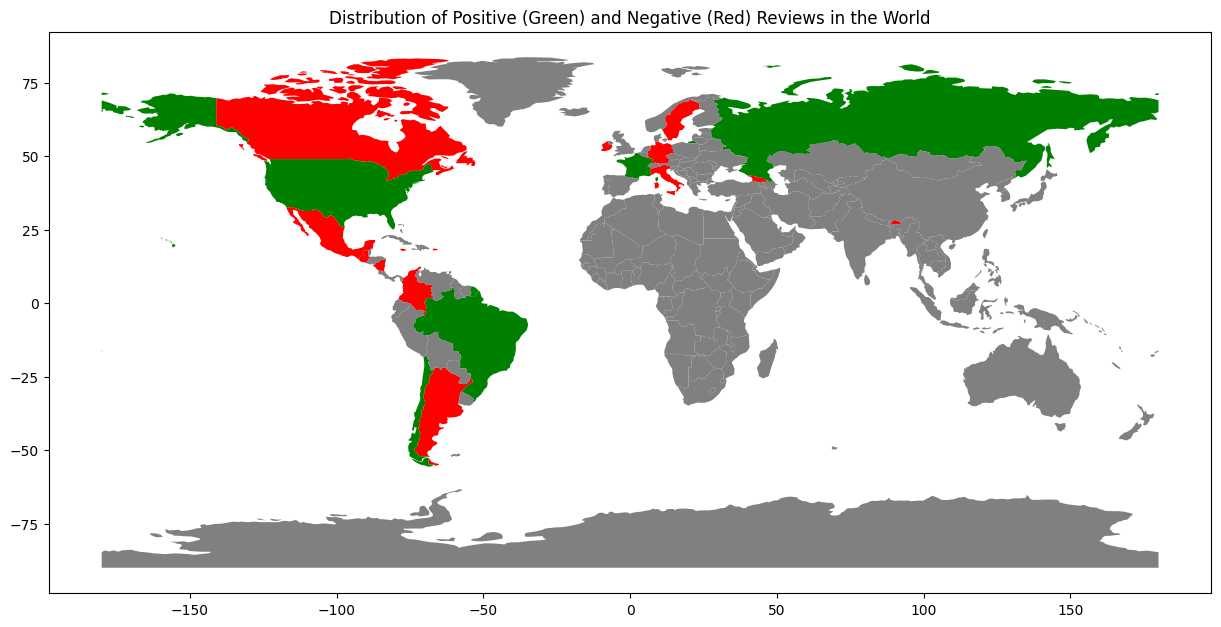

In [42]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your "tweets.csv" dataset using pandas
df = pd.read_csv('tweets.csv')

# Group data by "tweet location" and "sentiment" and calculate counts
sentiment_counts = df.groupby(['tweet_location', 'airline_sentiment']).size().unstack().fillna(0)

# Load a shapefile of world countries or regions
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge sentiment data with geographical data based on "tweet location"
world = world.merge(sentiment_counts, left_on='name', right_on='tweet_location', how='left')
world.fillna(0, inplace=True)

# Create a color-coded map with two colors (green for positive and red for negative, white for no data)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world['sentiment_color'] = 'grey'  # Initialize the sentiment color as white
world.loc[world['positive'] > 0, 'sentiment_color'] = 'green'  # Set positive regions to green
world.loc[world['negative'] > 0, 'sentiment_color'] = 'red'  # Set negative regions to red

world.plot(facecolor=world['sentiment_color'], ax=ax, legend=False)

plt.title("Distribution of Positive (Green) and Negative (Red) Reviews in the World")
plt.show()
